In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cclib
import pandas as pd

In [2]:
## Read theoretical TD-DFT data
def extract_tddft_data_for_files(directory, files):
    tddft_data = {}
    for log_file in files:
        file_path = os.path.join(directory, log_file)
        try:
            data = cclib.io.ccread(file_path)
            if hasattr(data, 'etenergies') and hasattr(data, 'etoscs'):
                #h = 6.62606876e-34 
                #c = 299792458    
                #eV_conversion = 1.6022e-19  
                #converted_energies = [((h*c/(energy))/eV_conversion) for energy in data.etenergies]
                converted_energies = [energy * 0.000123984 for energy in data.etenergies]
                oscillation_strengths = data.etoscs
                tddft_data[log_file] = (converted_energies, oscillation_strengths)
            else:
                print(f"No excited state data found in {log_file}.")
        except Exception as e:
            print(f"Error reading {log_file}: {e}")
    return tddft_data


# Directory and files
directory = "/Users/jennadraude/desktop/school/chem/research/PPV/plot"
#files = ["cisphenothiazine_monomer.log", "cisphenothiazine_2oligomer.log", "cisphenothiazine_3oligomer.log"]  
#files = ["transphenothiazine_monomer.log", "transphenothiazine_2oligomer.log", "transphenothiazine_3oligomer.log"] 
cis_files = ["cisbuet_monomer.log", "cisbuet_2oligomer.log", "cisbuet_3oligomer.log"]
#trans_files = ["transbuet_monomer.log", "transbuet_2oligomer.log", "transbuet_3oligomer.log"]
trans_files = ['first_250states.log']

# Extract data
cis_extracted_data = extract_tddft_data_for_files(directory, cis_files)
trans_extracted_data = extract_tddft_data_for_files(directory, trans_files)

extracted_data = {**cis_extracted_data, **trans_extracted_data} # combine for loops

In [3]:
## edit data as needed
def spectrum(E, osc, sigma, x):
    gE = []
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * np.exp(-(((Ej - Ei) / sigma) ** 2))
        gE.append(tot)
    return gE

'''
# Find the global maximum across all datasets
global_max = 0
for _, (energies, osc_strengths) in cis_extracted_data.items():
    x = np.linspace(min(energies) - 0.5, max(energies) + 0.5, num=10000)
    gE_raw = spectrum(energies, osc_strengths, sigma=0.05, x=x)
    global_max = max(global_max, np.max(gE_raw))

for _, (energies, osc_strengths) in trans_extracted_data.items():
    x = np.linspace(min(energies) - 0.5, max(energies) + 0.5, num=10000)
    gE_raw = spectrum(energies, osc_strengths, sigma=0.05, x=x)
    global_max = max(global_max, np.max(gE_raw))
'''

def normalize_osc_group(extracted_data):
    # Step 1: Find the global maximum oscillator strength across the group (e.g., cis or trans)
    global_max_osc = max([max(osc_strengths) for _, (_, osc_strengths) in extracted_data.items()])
    
    # Step 2: Normalize all oscillator strengths in the group using the global maximum
    normalized_data = {
        file_name: (energies, [o / global_max_osc for o in osc_strengths])
        for file_name, (energies, osc_strengths) in extracted_data.items()
    }
    
    return normalized_data

# Normalize oscillator strengths for cis and trans data separately
cis_extracted_data = normalize_osc_group(cis_extracted_data)
trans_extracted_data = normalize_osc_group(trans_extracted_data)


In [4]:
## pull experimental data

directory = "/Users/jennadraude/desktop/school/chem/research/PPV/plot"
cis_exp_file = os.path.join(directory, 'cis_buet.txt')
trans_exp_file = os.path.join(directory, 'trans_buet.txt')

# DataFrames
cis_exp_data = pd.read_csv(cis_exp_file, delim_whitespace=True, header=None, names=['energies', 'intensities'])
trans_exp_data = pd.read_csv(trans_exp_file, delim_whitespace=True, header=None, names=['energies', 'intensities'])

def convert_nm_to_ev(wavelength):
    h = 6.62606876e-34  
    c = 299792458    
    eV_conversion = 1.6022e-19 
    wavelengths_m = wavelength * 1e-9
    energies_J = h * c / wavelengths_m
    energies_eV = energies_J / eV_conversion
    return energies_eV

trans_exp_data['energies'] = convert_nm_to_ev(trans_exp_data['energies'])
cis_exp_data['energies'] = convert_nm_to_ev(cis_exp_data['energies'])

#normalize
def normalize_intensities(df):
    df['intensities'] = df['intensities'] / df['intensities'].max()

normalize_intensities(cis_exp_data)
normalize_intensities(trans_exp_data)

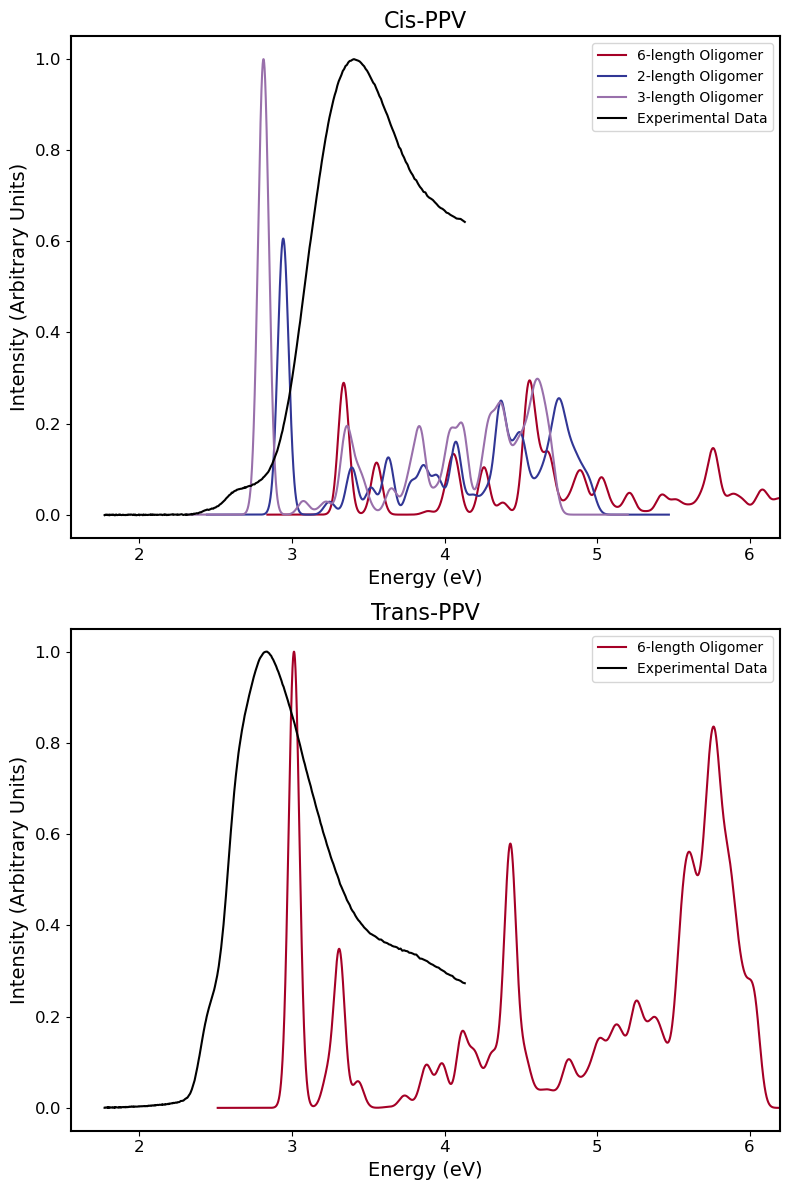

In [6]:
# Define colors and labels
colors = ['#a50026', '#313695', '#9970ab', '#000000']
labels_names = ['6-length Oligomer', '2-length Oligomer', '3-length Oligomer', 'Experimental Data']

# Plot settings
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
titles = ["Cis-PPV", "Trans-PPV"]

# Cis Data Plotting
for idx, (file_name, (energies, osc_strengths)) in enumerate(cis_extracted_data.items()):
    x = np.linspace(min(energies) - 0.5, max(energies) + 0.5, num=10000)
    gE_raw = spectrum(energies, osc_strengths, sigma=0.05, x=x)
    axes[0].plot(x, gE_raw, color=colors[idx], label=labels_names[idx])
    #gE_norm_global_max = gE_raw / global_max
    #axes[0].plot(x, gE_norm_global_max, color=colors[idx], label=labels_names[idx])

# Add experimental data for cis
axes[0].plot(cis_exp_data['energies'], cis_exp_data['intensities'], 
             color=colors[-1], label='Experimental Data')

axes[0].set_ylabel("Intensity (Arbitrary Units)", fontsize=14)
axes[0].legend(fontsize=10)
axes[0].set_xlim(convert_nm_to_ev(800), convert_nm_to_ev(200))

# Trans Data Plotting
for idx, (file_name, (energies, osc_strengths)) in enumerate(trans_extracted_data.items()):
    x = np.linspace(min(energies) - 0.5, max(energies) + 0.5, num=10000)
    gE_raw = spectrum(energies, osc_strengths, sigma=0.05, x=x)
    axes[1].plot(x, gE_raw, color=colors[idx], label=labels_names[idx])
    #gE_norm_global_max = gE_raw / global_max
    #axes[1].plot(x, gE_norm_global_max, color=colors[idx], label=labels_names[idx])

# Add experimental data for trans
axes[1].plot(trans_exp_data['energies'], trans_exp_data['intensities'], 
             color=colors[-1], label='Experimental Data')

axes[1].set_ylabel("Intensity (Arbitrary Units)", fontsize=14)
axes[1].legend(fontsize=10)
axes[1].set_xlim(convert_nm_to_ev(800), convert_nm_to_ev(200))

# Common formatting for both plots
for ax, title in zip(axes, titles):
    ax.set_xlabel("Energy (eV)", fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.tick_params(labelsize=12)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

# Layout and save
plt.tight_layout()
save_path = "/Users/jennadraude/desktop/spectrum_plot.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
